# Connecting Google sheets.

In [17]:
import os
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SERVICE_ACCOUNT_FILE = r'C:\Users\HP\Desktop\eNPS\gen-lang-client-0660452616-7f8dc01be13a.json'
SHEET_ID = '10ET8bZJ5GbTS6oCb8Qdq4uUoSV7bgNwPEYhoELOQhNA'  

try:
    creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    
    result = service.spreadsheets().values().get(
        spreadsheetId=SHEET_ID, 
        range="Sheet1!A1:E81"
    ).execute()
    
    # Print data
    values = result.get('values', [])
    if not values:
        print("No data found.")
    else:
        for row in values:
            print(row)
        
except FileNotFoundError:
    print("Service account file not found.")
except Exception as e:
    print(f"Error: {e}")


['Employee ID', 'Department', 'Tenure (Months)', 'eNPS Score', 'Feedback']
['1', 'Marketing', '12', '9', '"Great company culture, supportive team!"']
['2', 'Engineering', '36', '7', '"Good benefits, but could use more challenging projects."']
['3', 'Sales', '24', '10', '"Love my job and the people I work with."']
['4', 'HR', '48', '8', '"Excellent work-life balance, but salary could be higher."']
['5', 'Finance', '6', '5', '"Feeling a bit overwhelmed with workload."']
['6', 'IT', '18', '9', '"Supportive management, opportunities for growth."']
['7', 'Marketing', '30', '6', '"Lack of communication from upper management."']
['8', 'Engineering', '12', '10', '"Best job I\'ve ever had!"']
['9', 'Sales', '42', '7', '"Would like more training opportunities."']
['10', 'HR', '24', '8', '"Enjoy my colleagues, but feel underappreciated."']
['11', 'Finance', '36', '5', '"Too much bureaucracy, slow decision-making."']
['12', 'IT', '6', '9', '"Great team environment, learning a lot."']
['13', 'Marke

transforming to DF

In [18]:
import pandas as pd

try:
    if not values:
        print("No data to process.")
    else:
        # Convert to DataFrame
        headers = values[0]  # First row as column headers
        data = values[1:]    # Remaining rows as data
        df = pd.DataFrame(data, columns=headers)

        print("Data loaded into DataFrame:")
        print(df.head())  
except Exception as e:
    print(f"Error during DataFrame creation: {e}")


Data loaded into DataFrame:
  Employee ID   Department Tenure (Months) eNPS Score  \
0           1    Marketing              12          9   
1           2  Engineering              36          7   
2           3        Sales              24         10   
3           4           HR              48          8   
4           5      Finance               6          5   

                                            Feedback  
0          "Great company culture, supportive team!"  
1  "Good benefits, but could use more challenging...  
2          "Love my job and the people I work with."  
3  "Excellent work-life balance, but salary could...  
4         "Feeling a bit overwhelmed with workload."  


In [3]:
df

,Employee ID,Department,Tenure (Months),eNPS Score,Feedback
0,1,Marketing,12,9,"""Great company culture, supportive team!"""
1,2,Engineering,36,7,"""Good benefits, but could use more challenging..."
2,3,Sales,24,10,"""Love my job and the people I work with."""
3,4,HR,48,8,"""Excellent work-life balance, but salary could..."
4,5,Finance,6,5,"""Feeling a bit overwhelmed with workload."""
...,...,...,...,...,...
75,76,HR,18,8,"""Good benefits, but could use more flexible wo..."
76,77,Finance,6,5,"""Feeling micromanaged by my manager."""
77,78,IT,30,9,"""Supportive team environment, opportunities fo..."
78,79,Marketing,12,6,"""Not happy with the company's direction."""


Data Cleaning

In [19]:
# Fill missing values and convert data types
df['Tenure (Months)'] = df['Tenure (Months)'].fillna(0).astype(int) 
df['Feedback'] = df['Feedback'].fillna('No Feedback')  
df['Department'] = df['Department'].str.strip().str.lower()  

# Create derived features
df['Tenure_Years'] = df['Tenure (Months)'] / 12  

# One-hot encode the Department column
df_encoded = pd.get_dummies(df, columns=['Department'], prefix='Dept', drop_first=True)

# Clean feedback text
df_encoded['Feedback_Cleaned'] = df_encoded['Feedback'].str.lower().str.strip()

# Save cleaned data
output_path = "C:/Users/HP/Desktop/eNPS/cleaned_eNPS_data.xlsx"
df_encoded.to_excel(output_path, index=False)
print(f"Transformed dataset saved to {output_path}")


Transformed dataset saved to C:/Users/HP/Desktop/eNPS/cleaned_eNPS_data.xlsx


# Encoding

In [20]:
# Convert boolean values in department columns to numeric (1/0)
dept_columns = [col for col in df_encoded.columns if col.startswith('Dept_')]
for col in dept_columns:
    df_encoded[col] = df_encoded[col].map({True: 1, False: 0})

# Clean eNPS Score - convert to numeric
df_encoded['eNPS Score'] = pd.to_numeric(df_encoded['eNPS Score'], errors='coerce')

# Verify the department encoding
print("Sample of encoded data:")
print(df_encoded[dept_columns].head())

Sample of encoded data:
   Dept_finance  Dept_hr  Dept_it  Dept_marketing  Dept_sales
0             0        0        0               1           0
1             0        0        0               0           0
2             0        0        0               0           1
3             0        1        0               0           0
4             1        0        0               0           0


# Sentimental analysis

In [25]:
from transformers import pipeline


sentiment_analyzer = pipeline("sentiment-analysis")


def get_sentiment(text):
    if isinstance(text, str) and text != 'no feedback':
        
        sentiment = sentiment_analyzer(text)
        # Return the sentiment score (0 for neutral, positive/negative scores)
        return sentiment[0]['score'] if sentiment[0]['label'] == 'POSITIVE' else -sentiment[0]['score']
    return 0
df_encoded['Sentiment_Score'] = df_encoded['Feedback_Cleaned'].apply(get_sentiment)

# Display the updated dataframe with sentiment scores
print(df_encoded[['Feedback_Cleaned', 'Sentiment_Score']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

                                    Feedback_Cleaned  Sentiment_Score
0          "great company culture, supportive team!"         0.999883
1  "good benefits, but could use more challenging...         0.992840
2          "love my job and the people i work with."         0.999874
3  "excellent work-life balance, but salary could...         0.987063
4         "feeling a bit overwhelmed with workload."        -0.960526


In [26]:
# Categorize eNPS scores with Hugging Face or sentiment-based analysis if needed
def categorize_enps(score, sentiment_score=None):
 
    if pd.isna(score) or score == 0:
        return 'No Score'
    
    # You can include sentiment_score influence if you'd like to add a layer of sentiment-based categorization
    elif score >= 9:
        return 'Promoter'
    elif score >= 7:
        return 'Passive'
    else:
        return 'Detractor'

df_encoded['eNPS_Category'] = df_encoded.apply(lambda row: categorize_enps(row['eNPS Score'], row['Sentiment_Score']), axis=1)

# Check the updated categories
print(df_encoded[['eNPS Score', 'Sentiment_Score', 'eNPS_Category']].head())


   eNPS Score  Sentiment_Score eNPS_Category
0         9.0         0.999883      Promoter
1         7.0         0.992840       Passive
2        10.0         0.999874      Promoter
3         8.0         0.987063       Passive
4         5.0        -0.960526     Detractor


In [29]:
# Calculate overall eNPS using the categorized data
promoters = (df_encoded['eNPS_Category'] == 'Promoter').mean()
detractors = (df_encoded['eNPS_Category'] == 'Detractor').mean()

print(promoters,'promoters_avg')
print(detractors,'detractors_avg')
# Calculate eNPS score
enps = (promoters - detractors) * 100

# Basic analysis (overall eNPS)
print(f"Overall eNPS Score: {enps:.1f}")
print("\nDistribution of eNPS Categories:")
print(df_encoded['eNPS_Category'].value_counts())

# Department-wise analysis
print("\nAverage eNPS Score by Department:")
for col in dept_columns:
    dept_name = col.replace('Dept_', '')
    # Average eNPS score for each department based on the 'eNPS Score'
    avg_score = df_encoded[df_encoded[col] == 1]['eNPS Score'].mean()
    print(f"{dept_name}: {avg_score:.1f}")



0.3375 promoters_avg
0.325 detractors_avg
Overall eNPS Score: 1.3

Distribution of eNPS Categories:
eNPS_Category
Promoter     27
Passive      26
Detractor    26
No Score      1
Name: count, dtype: int64

Average eNPS Score by Department:
finance: 5.0
hr: 8.0
it: 9.0
marketing: 6.2
sales: 7.2


In [28]:
# Save enhanced analysis with sentiment and categorized eNPS data
output_path = "C:/Users/HP/Desktop/eNPS/analyzed_eNPS_data.xlsx"
df_encoded.to_excel(output_path, index=False)
print(f"\nAnalyzed dataset saved to {output_path}")



Analyzed dataset saved to C:/Users/HP/Desktop/eNPS/analyzed_eNPS_data.xlsx


# Topic modeling

Topic #1:


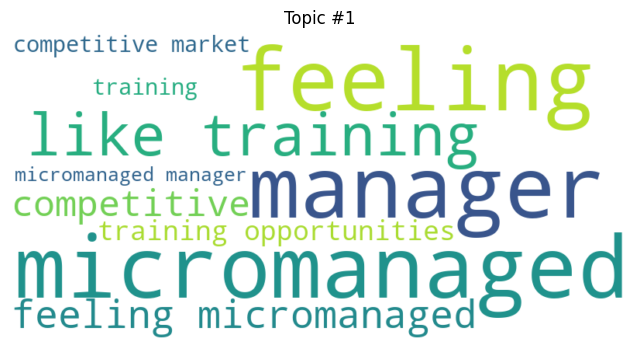

Topic #2:


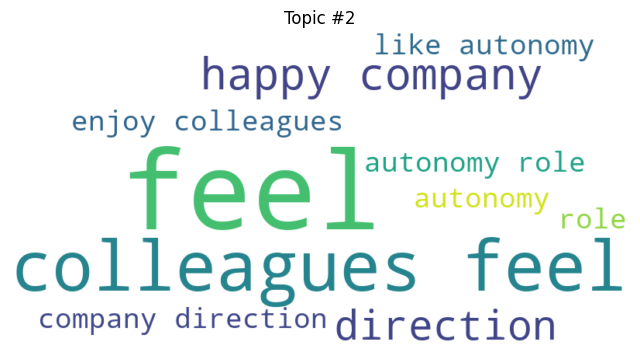

Topic #3:


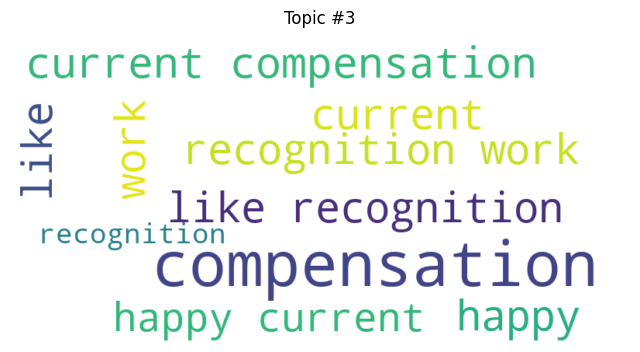

Topic #4:


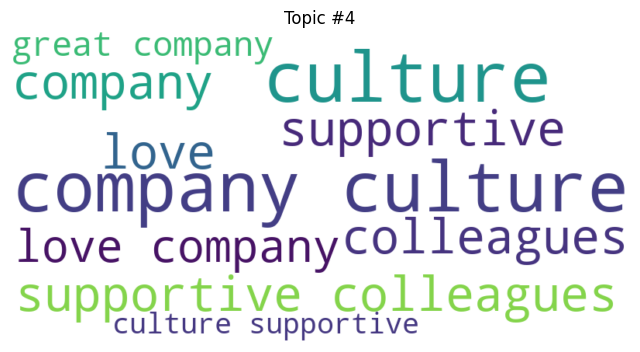

Topic #5:


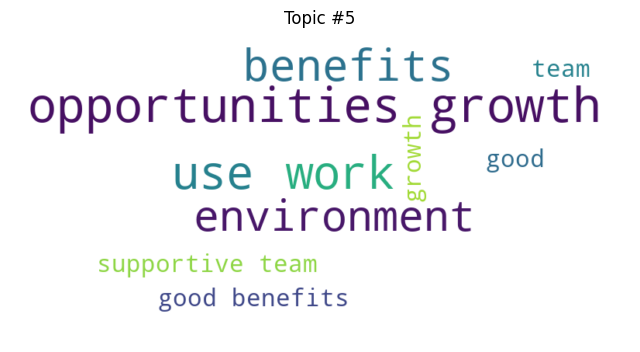

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample text data
texts = df_encoded['Feedback_Cleaned'].values  # or another column containing feedback

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)
X = vectorizer.fit_transform(texts)

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Choose number of topics
lda.fit(X)

# Create word clouds for each topic
for index, topic in enumerate(lda.components_):
    print(f"Topic #{index + 1}:")
    words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]  # top 10 words for the topic
    word_freq = {word: topic[i] for i, word in enumerate(words)}  # Word frequencies for the cloud

    # Generate the WordCloud
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{index + 1}")
    plt.show()
